# Independent Experiment Analysis
## Treats each row as its own experiment and analyzes each row independently

In [2]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data
from helpers import *
from drift_file_io import drift_input, calculate_average_timestep, merge_lines, experiment_per_line
#################################################################################################################
#For reading in experimental data: enter here
base = "N:/Programs/Ions Share/Gate-Set Tomography/DriftAnalysis/"
name = '2018_08_27 Gi Data/2018_08_27_1354_31_DRIFT'
file_loc = base + name + ".txt"
time_per_sample = 1/60 #seconds, only necessary if you're doing the manual entry
savepath = None
save = False
if save:
    savepath = base + name + "_Independent_Experiments" + ".png"
    
time_per_sample = 1/60 #seconds

experiments = experiment_per_line(file_loc, time_per_sample)###Currently reading each line as an experiment
num_experiments = len(experiments)
results_list = []
plots_list = []
data_lists = []
top_freqs = []
top_freqs_occurence = []
nSamples = 0
##############################################################################################################
#Don't change anything below this line for regular program operation

for exp_index in range(num_experiments):
    #Initialize arrays of one-counts per timestep, zero-counts per timstep, the actual timesteps for each, and the probability of getting a 1 for each
    ones_count_array = []
    zeros_count_array = []
    timestamp_array = [] #time in seconds
    ones_count_array, zeros_count_array, timestamp_array = experiments[exp_index]
    nSamples = len(ones_count_array)
    exp_data = ()
    
    counts_per_timestep = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
    drifted = drift.do_basic_drift_characterization(ones_count_array, counts=counts_per_timestep, timestep=time_per_sample,timestamps=timestamp_array, verbosity = 0)
    results_list.append(drifted)
    
    #analyze the frequency-power spectrum
    frequencies = list(drifted.frequencies)
    power_spectrum = list(drifted.pspepo_power_spectrum[0,0,1,:])
    grouped = []
    for i in range(len(frequencies)):
        grouped.append((frequencies[i], power_spectrum[i]))
    sorted_groups = sorted(grouped, key=lambda tup: tup[1], reverse=True)
    num_points = 5
    for i in range(num_points):
        exp_data = exp_data + ("#{}: {:.3f} Hz".format(i+1, sorted_groups[i][0]),)
        if i == 0:
            top_freqs.append(sorted_groups[i][0])
    data_lists.append(exp_data)



C:\Users\GA28573\Documents\pyGSTi-master\packages\pygsti\tools\matrixtools.py:23: UserWarning: Could not import Cython extension - falling back to slower pure-python routines
  _warnings.warn("Could not import Cython extension - falling back to slower pure-python routines")


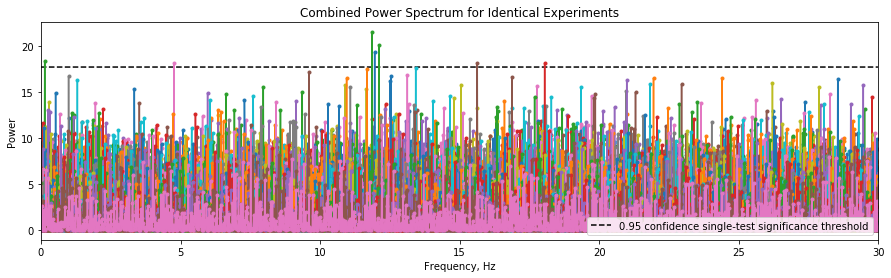

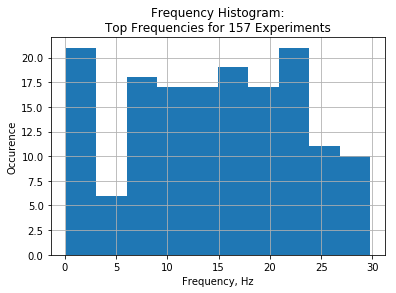

In [3]:
confidence_is_plotted = False

fig = plt.figure(figsize=(15,4))
for results in results_list:
    plt.plot(results.frequencies,results.pspepo_power_spectrum[0,0,1,:],ls="solid",marker='.')
    if not(confidence_is_plotted):plt.plot(results.frequencies,results.pspepo_significance_threshold_1test*np.ones(results.number_of_timesteps),'k--', 
                  label=str(results.confidence)+' confidence single-test significance threshold')
    confidence_is_plotted = True
plt.legend(loc="lower right")
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((0,results_list[0].frequencies[-1]))
plt.title("Combined Power Spectrum for Identical Experiments")
if save: plt.savefig(base  + name + "_Independent_Experiments" + ".png")
plt.show()

plt.hist(top_freqs)
plt.xlabel("Frequency, Hz")
plt.ylabel("Occurence")
plt.grid()
plt.title("Frequency Histogram:\nTop Frequencies for {} Experiments".format(num_experiments))
plt.show()

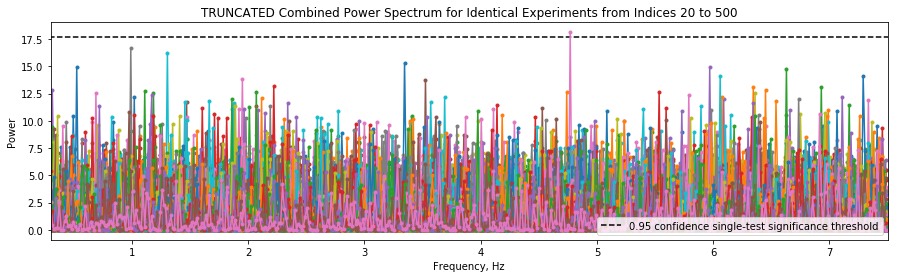

In [4]:
############################ Use this cell to truncate the data as needed for plotting purposes
confidence_is_plotted = False
mindex = 20
maxdex = 500

fig = plt.figure(figsize=(15,4))
for results in results_list:
    plt.plot(results.frequencies[mindex:maxdex],results.pspepo_power_spectrum[0,0,1,:][mindex:maxdex],ls="solid",marker='.')
    if not(confidence_is_plotted):plt.plot(results.frequencies,results.pspepo_significance_threshold_1test*np.ones(results.number_of_timesteps),'k--', 
                  label=str(results.confidence)+' confidence single-test significance threshold')
    confidence_is_plotted = True
plt.legend(loc="lower right")
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((results_list[0].frequencies[mindex],results_list[0].frequencies[maxdex]))
plt.title("TRUNCATED Combined Power Spectrum for Identical Experiments from Indices {} to {}".format(mindex, maxdex))
plt.show()

!!!!!! Power is averaged here! Previous saved versions just have the powers summed!


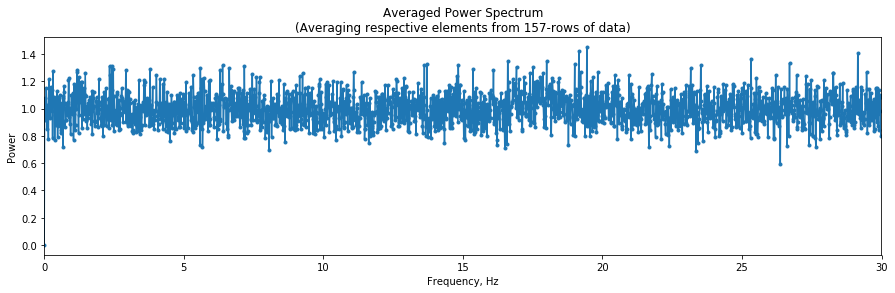

#1 Frequency: 19.4400 Hz
#2 Frequency: 19.1550 Hz
#3 Frequency: 29.1450 Hz
#4 Frequency: 25.3200 Hz
#5 Frequency: 16.6050 Hz


In [5]:
superimposed_power_spectrum = np.zeros(len(results_list[0].pspepo_power_spectrum[0,0,1,:]))
superimposed_frequencies = results_list[0].frequencies
for result in results_list:
    for index in range(len(superimposed_power_spectrum)):
        power = result.pspepo_power_spectrum[0,0,1,:][index]
        superimposed_power_spectrum[index] += power
#here I'm dividing the superimposed power by the number of experiments to get an average
average = True
if average:
    superimposed_power_spectrum = superimposed_power_spectrum/num_experiments
    print("!!!!!! Power is averaged here! Previous saved versions just have the powers summed!")
        
fig = plt.figure(figsize=(15,4))
plt.plot(superimposed_frequencies, superimposed_power_spectrum,ls="solid",marker='.')
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((0,superimposed_frequencies[-1]))
if average:
    plt.title("Averaged Power Spectrum\n(Averaging respective elements from {}-rows of data)".format(num_experiments))
else:
    plt.title("Superimposed Power Spectrum\n(Summing respective elements from {}-rows of data)".format(num_experiments))
if save: plt.savefig(base  + name + "_Superimposed_Independent_Experiments" + ".png")
plt.show()

#analyze the frequency-power spectrum
grouped = []
for i in range(len(superimposed_frequencies)):
    grouped.append((superimposed_frequencies[i], superimposed_power_spectrum[i]))
sorted_groups = sorted(grouped, key=lambda tup: tup[1], reverse=True)
num_points = 5
for i in range(num_points):
    print("#{} Frequency: {:.4f} Hz".format(i+1, sorted_groups[i][0]))

if save == True:
    with open(base+name+"_Superimposed_Data.txt", "w") as file:
        for index in range(len(superimposed_frequencies)):
            f = superimposed_frequencies[index]
            p = superimposed_power_spectrum[index]
            file.write("{}\t{}\n".format(f,p))

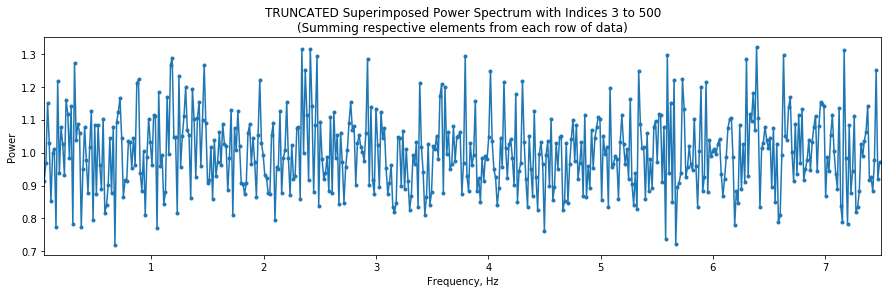

In [6]:
################ This is another area for truncating the data, but for the superimposed spectrum
mindex = 3
maxdex = 500#len(superimposed_frequencies) - 1

fig = plt.figure(figsize=(15,4))
plt.plot(superimposed_frequencies[mindex:maxdex], superimposed_power_spectrum[mindex:maxdex],ls="solid",marker='.')
plt.xlabel("Frequency, Hz")
plt.ylabel("Power")
plt.xlim((superimposed_frequencies[mindex],superimposed_frequencies[maxdex]))
plt.title("TRUNCATED Superimposed Power Spectrum with Indices {} to {}\n(Summing respective elements from each row of data)".format(mindex, maxdex))
plt.show()

In [7]:
####getting statistics on the powers fors 1.2 Hz in each experiment row

freq_band = 0.02 #Hz
central_freq = 1.2 #Hz
power_bins = [0]*num_experiments

low_index = 0
high_index = 0
for i in range(len(results_list[0].frequencies)):
    freq = results_list[0].frequencies[i]
    #print(freq)
    if freq >= (central_freq - freq_band) and low_index == 0:
        low_index = i
    if freq >= (central_freq + freq_band) and high_index == 0:
        high_index = i
        
for result in results_list:
    res_index = results_list.index(result)
    res_powers = result.pspepo_power_spectrum[0,0,1,:]
    for i in range(low_index, high_index):
        #print("freq is {} Hz".format(result.frequencies[i]))
        #print("Power here is {}".format(res_powers[i]))
        power_bins[res_index] += res_powers[i]
        
        
'''plt.plot(range(num_experiments), power_bins)
plt.xlabel("Experiment index")
plt.ylabel("Total 1.2 Hz band power")
plt.show()'''

import statistics as stat
mean_power = stat.mean(power_bins)
sigma_power = stat.stdev(power_bins)

print('Mean power at {} +/- {} Hz is {:.2f} with stdev {:.2f}'.format(central_freq, freq_band, mean_power, sigma_power))

Mean power at 1.2 +/- 0.02 Hz is 3.38 with stdev 2.95


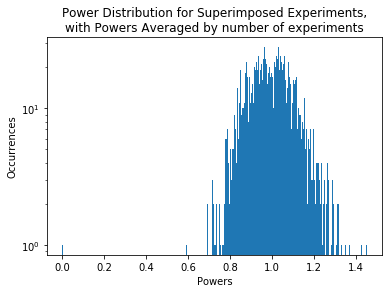

In [8]:
############ plot the distribution of powers
plt.hist(superimposed_power_spectrum, bins = 500, log=True)
plt.xlabel("Powers")
plt.ylabel("Occurrences")
plt.title("Power Distribution for Superimposed Experiments,\nwith Powers Averaged by number of experiments")
plt.show()


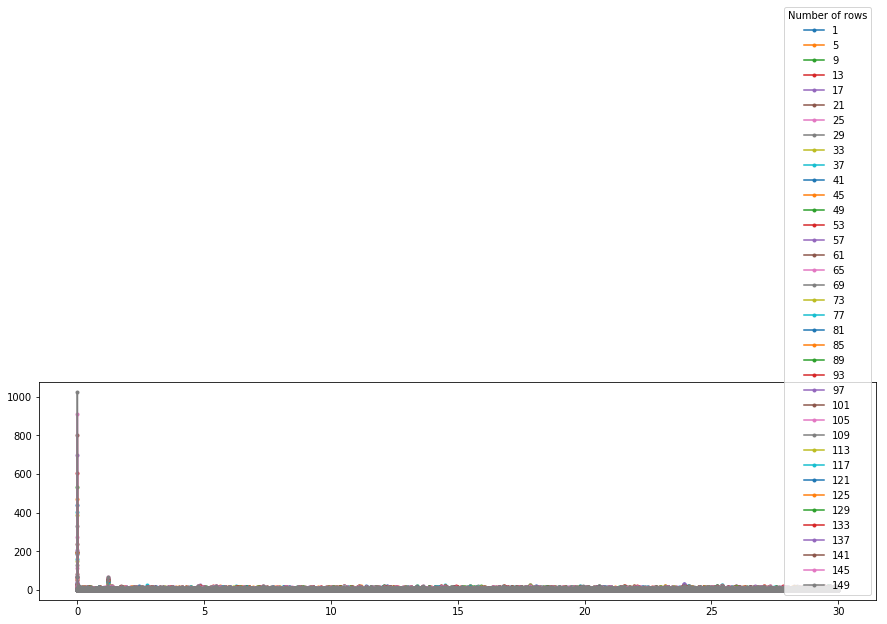

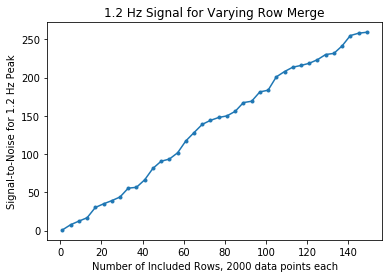

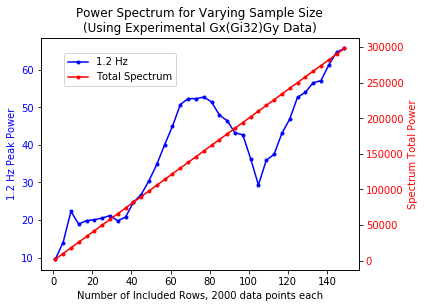

Slope is 1.0 power units per data_point
Total Power = 1.000*num_points + 0.000


In [9]:
#######seeing how many rows you have to merge IOT see a peak at 1.2 Hz
time_per_sample = 1/60 #seconds
drifted_list = []
num_row_list = []
snr_list = []
total_power_list = []
max_power_list = []
freq_band = 0.01 #Hz
central_freq = 1.2 #Hz
starting_num_rows = 1
ending_num_rows = 150 #inclusive

plt.figure(figsize=(15,4))
for num_row in range(starting_num_rows, ending_num_rows + 1, 4):
    ones_count_array, zeros_count_array, timestamp_array = merge_lines(file_loc, time_per_sample, num_rows = num_row)  
    counts_per_timestep = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
    drift_obj = drift.do_basic_drift_characterization(ones_count_array, counts=counts_per_timestep, timestep=time_per_sample,timestamps=timestamp_array, verbosity = 0)
    plt.plot(drift_obj.frequencies, drift_obj.pspepo_power_spectrum[0,0,1,:], label=num_row, marker='.')
    num_row_list.append(num_row)
    max_pow = find_max_power(drift_obj.frequencies, drift_obj.pspepo_power_spectrum[0,0,1,:], central_freq-freq_band, central_freq+freq_band)
    max_power_list.append(max_pow)
    total_power = np.sum(drift_obj.pspepo_power_spectrum[0,0,1,:])
    total_power_list.append(total_power)
    snr = SNR(drift_obj.frequencies, drift_obj.pspepo_power_spectrum[0,0,1,:], [central_freq], freq_band)
    snr_list.append(snr)
    
plt.legend(title="Number of rows", loc="lower right")
plt.show()

plt.plot(num_row_list, snr_list,marker='.')
plt.title("1.2 Hz Signal for Varying Row Merge")
plt.xlabel("Number of Included Rows, {} data points each".format(nSamples))
plt.ylabel("Signal-to-Noise for 1.2 Hz Peak")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("Number of Included Rows, {} data points each".format(nSamples))
ax1.set_ylabel('1.2 Hz Peak Power', color="blue")
ax1.tick_params(axis='y', labelcolor='blue')
ax1.plot(num_row_list, max_power_list, marker='.',label="1.2 Hz", color='blue')
ax2.set_ylabel('Spectrum Total Power', color="red")
ax2.plot(num_row_list, total_power_list, marker='.', label="Total Spectrum", color="red")
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
fig.legend(loc=(0.15, 0.72))
plt.title("Power Spectrum for Varying Sample Size\n(Using Experimental Gx(Gi32)Gy Data)")
plt.show()

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(np.asarray(num_row_list)*nSamples, total_power_list)
print("Slope is {:.1f} power units per data_point".format(slope))
print("Total Power = {:.3f}*num_points + {:.3f}".format(slope, intercept))

